# Regression Fundamentals: Comparing Samples

This notebook is the first in a five-part series covering foundational
statistics and the building blocks for regression modelling. This
session walks through the process of comparing samples, demonstrating
**why** comparisons matter and how we approach them, and applies these
ideas using data on fatal car crashes in the U.S.

We will discuss why we compare groups in data analysis, the differences
between population and sample data, how to visualise and interpret group
differences, and how to assess whether differences are statistically
meaningful.

The goal of this session is for everyone to understand the role of
comparison in statistics, as well as to recognise what comparisons
between groups can tell us and what their limitations are.

## Why Compare?

Comparison is fundamental to how we learn from data. When we observe
something in data, whether it is a specific observation, a broader
pattern across observations, or the outcome of a calculation, we need
context to understand its meaning. Is this value high or low? Is it
unusual? Should we pay more attention to it?

Imagine an online store making changes to its website with the intention
of boosting sales. After a week, the changes made generated £250k in
sales. Is that good? We don’t know because we don’t have anything to
compare against. The store could compare this figure to the sales from
the previous week. Better yet, they could run the original version of
the website concurrently alongside the new version, serving different
versions of the website to users at random, to more directly compare
sales. If the original version of the website generated only £230k in
sales, we now have a meaningful comparison that suggests that the new
version of the site may boost sales.

Raw numbers rarely tell us complete stories. A patient’s blood pressure
is only meaningful because we know what a healthy range is, and we can
use this for comparison. Without comparison, data is meaningless.

### What does Comparison Really Tell Us?

When we compare two groups in our data, what we *really* want to know is
whether those groups differ in the real world, not just whether they
differ in the data. The comparison in the data serves as a proxy for
understanding differences in the wild. The data is a “sample” of what
the real world (the population) looks like. But suppose we see a
difference between two groups in our data. How do we know if that
reflects a difference that is occurring in the population, instead of
being caused by random variation in the data?

Separating real patterns, or signal, from the noise in data is a
fundamental part of statistics and is the driving force behind
everything in statistical inference. Good comparisons account for the
possibility of random variation and consider the ways in which the
comparisons we are making may be flawed or incomplete. If the online
store compared the previous week’s sales, this would still be useful,
but what if the previous week included a holiday that led to a
significant boost of sales, or the week the new site was launched was
payday for a lot of customers? It is important to consider whether your
comparison is really meaningful.

**Questions:**

-   How do you currently decide whether the difference you observe in
    your data is real or occurred by chance?
-   Why is it important to know if differences observed in data occurred
    by chance?

### Population vs. Sample

The population is every possible unit or observation relevant to what
you are studying, while the sample is a subset of the population. If you
wanted to estimate how income affects housing prices in UK cities, the
population would be every city in the UK. A sample would be data
covering a handful of (hopefully representative) cities.

<figure>
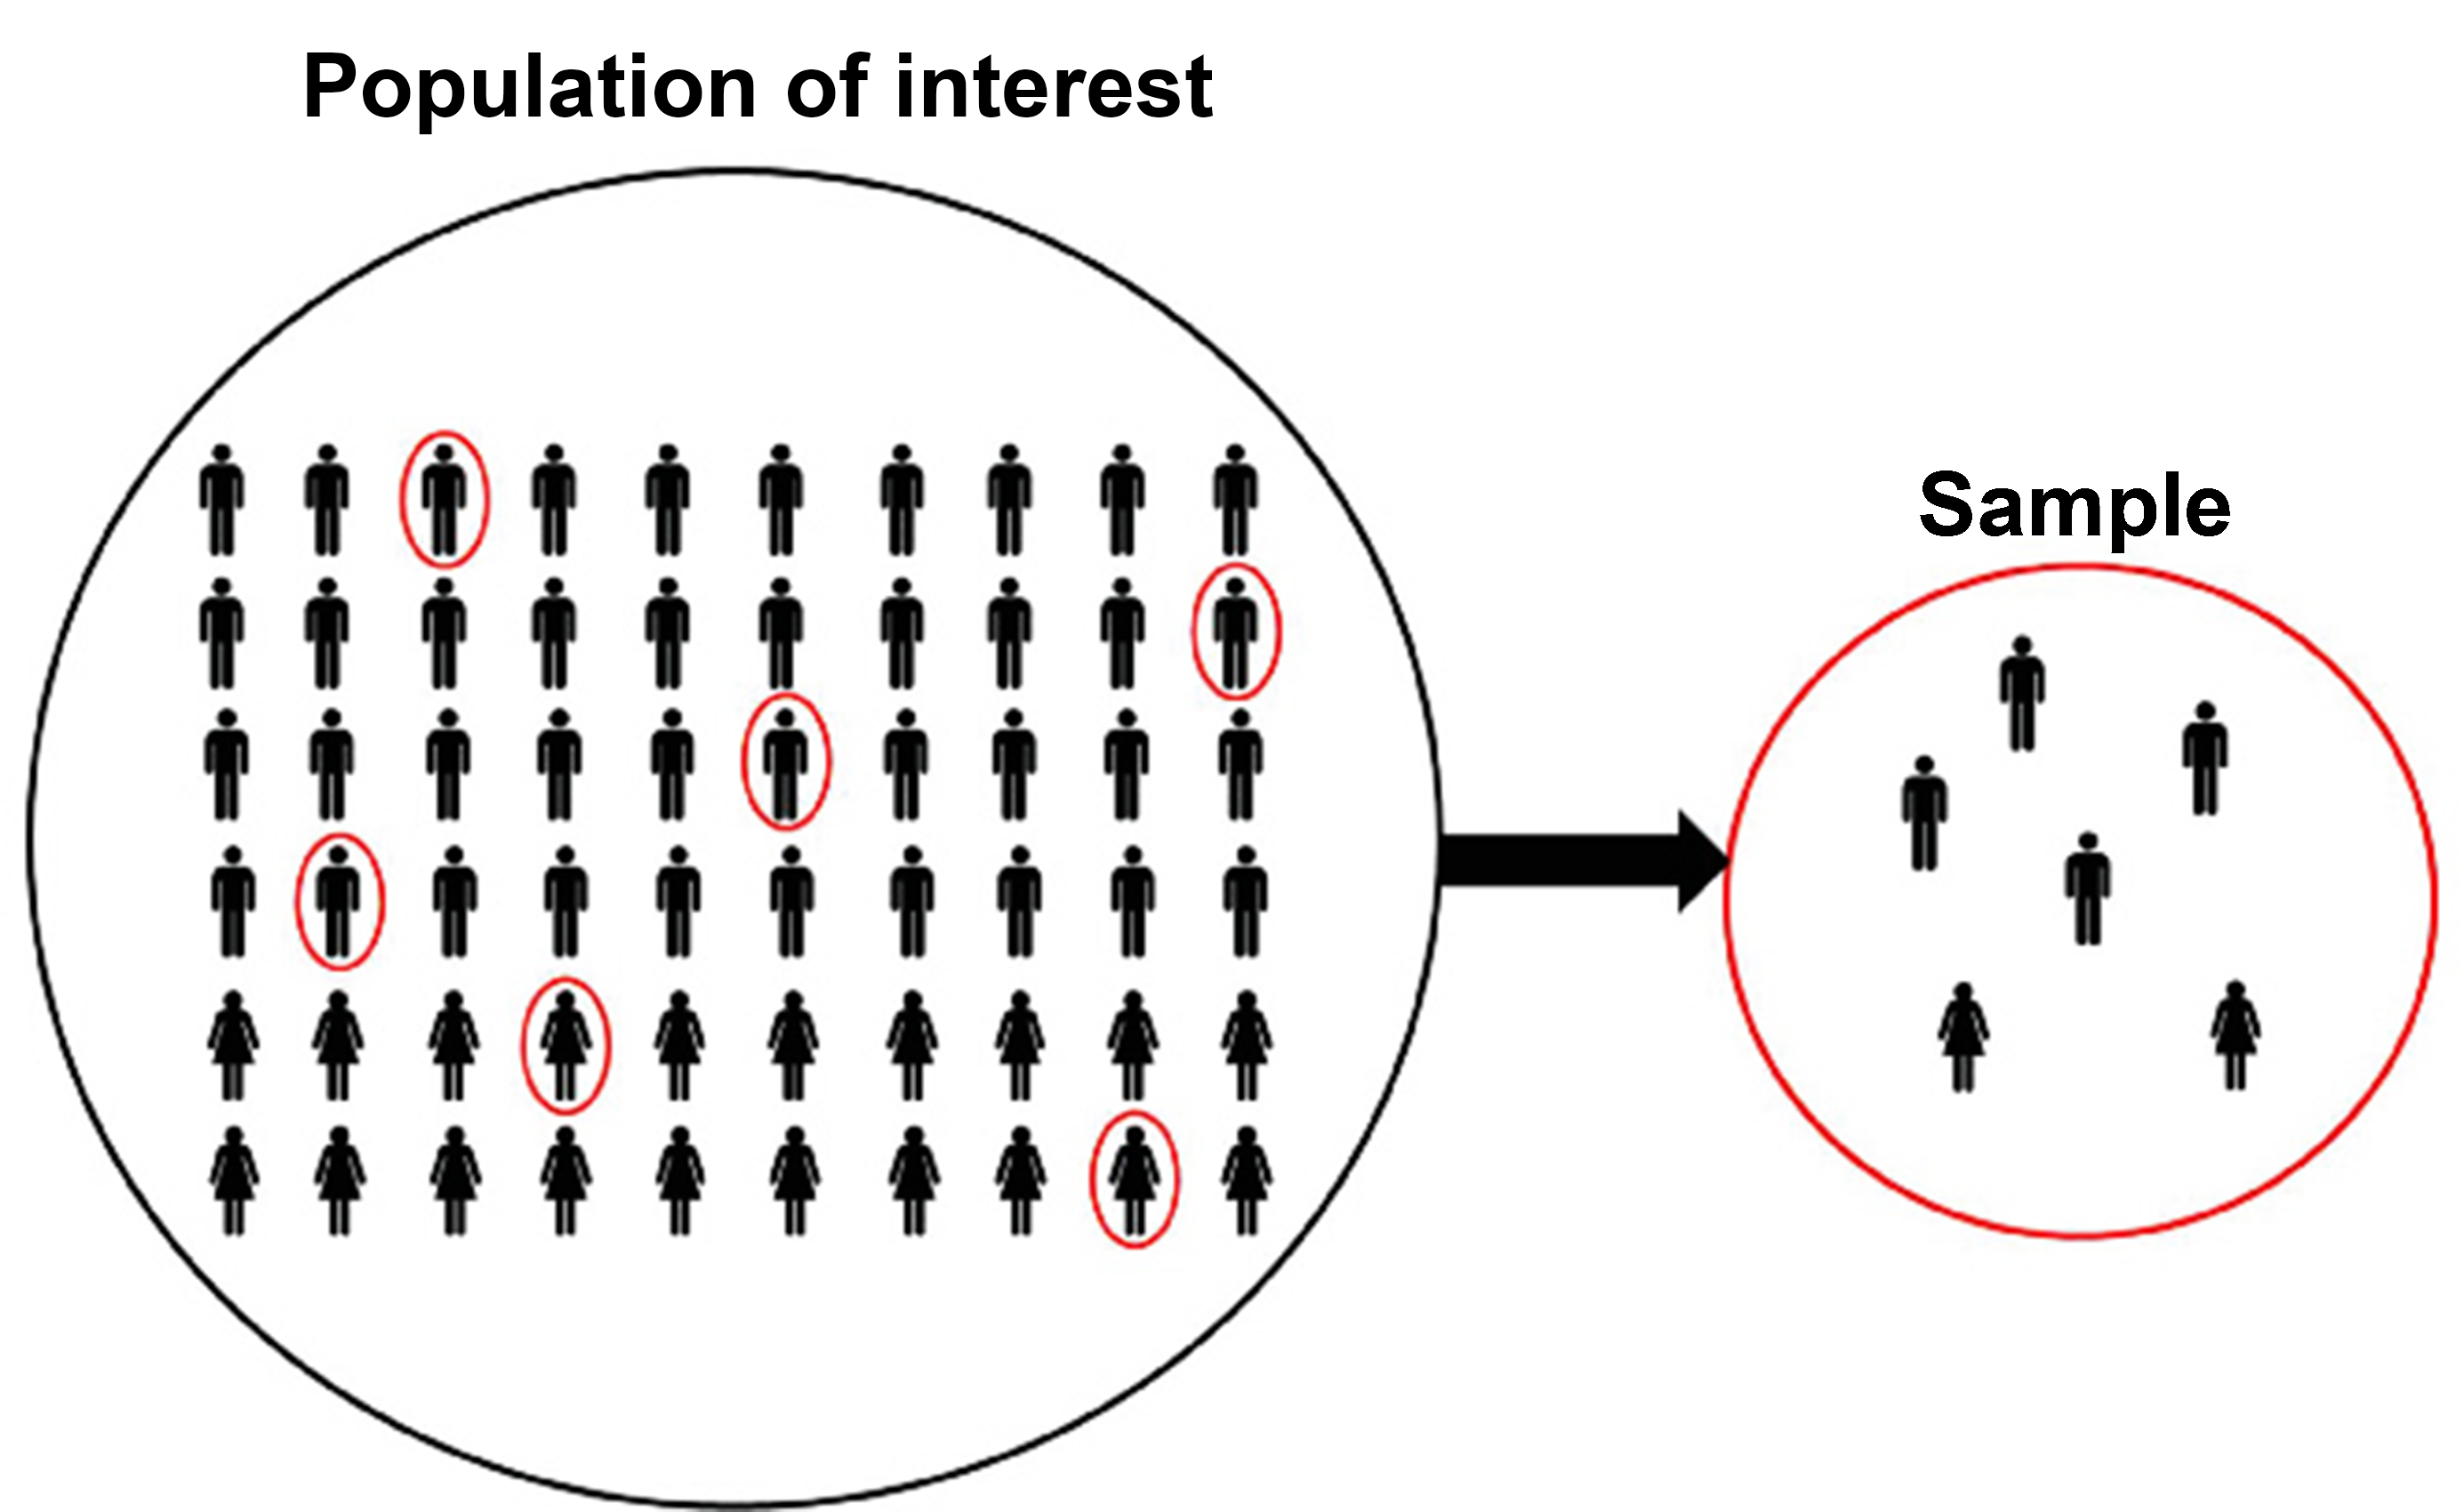
<figcaption aria-hidden="true">Source: <a
href="https://www.let.rug.nl/wieling/Statistiek-I/HC2/">Martijn
Wieling</a></figcaption>
</figure>

If we had access to the entire population, comparisons would be
straightforward. However, we usually don’t, so we have to take a sample
of the population and make inferences about the population based on our
sample. That means dealing with uncertainty, variation, and potential
bias.

To compare groups responsibly, we need to consider how sampling affects
what we observe and how it may limit our ability to make accurate
comparisons. The sample is a small snapshot of the population, and there
are several reasons why it might not be representative of the wider
population.

Below is an example illustrating the difference between the population
and the sample, simulating drawing ten cards from a standard deck and
calculating the average value of the cards drawn.

In [1]:
import numpy as np
import random

# simulate drawing 10 cards from a standard deck
deck = list(range(1, 14)) * 4

# draw two random samples of ten cards
sample1 = random.sample(deck, 10)
sample2 = random.sample(deck, 10)

# compute sample means
sample_mean1 = np.mean(sample1)
sample_mean2 = np.mean(sample2)

# compute population mean
population_mean = np.mean(deck)

print(f"Sample means: {sample_mean1}, {sample_mean2}")
print(f"Population mean: {population_mean}")

Sample means: 7.8, 6.6
Population mean: 7.0

We have taken two samples from the population. Their mean values are 7.8
and 7.8, which vary slightly from the population mean (7.0). Why do the
sample means differ from each other and the population mean?

Sampling variability is inevitable. Each sample captures only a slice of
the full population, and in small samples, this can lead to significant
variances in the sample and population means. Perhaps the first ten
cards drawn from the deck have a high number of face cards, or the
second sample has lots of 2s, 3s, and 4s. Even if the process for
drawing a sample is fair, individual samples will always vary. This is a
core challenge of inference. We rely on well-designed comparisons to
manage these uncertainties, using statistical tools that help us
determine whether sample-level observations likely reflect real
population-level differences.

## Comparing Car Crash Fatalities - High or Not?

Now we can apply this logic to a real-world dataset. We will use a [Tidy
Tuesday](https://github.com/rfordatascience/tidytuesday/blob/main/data/2025/2025-04-22/readme.md)
dataset that records the daily count of fatal U.S. car crashes from
1992–2016, originally from a [study into the effects of the annual
cannabis holiday (4:20pm to 11:59pm on April 20th), 4/20, on fatal car
accidents](https://injuryprevention.bmj.com/content/25/5/433).

While previous research has concluded that fatalities are higher on
4/20, suggesting that the holiday is the cause of the increase, Harper
and Palayew find no evidence for an increase in fatalities on 4/20, but
they do find an increase for other holidays like July 4th. We will
investigate whether we can see a spike in fatalities on 4/20 by
comparing 4/20 with other days of the year.

### Import & Process Data

In [2]:
import pandas as pd

# load data
raw_420 = pd.read_csv('data/daily_accidents_420.csv', parse_dates=['date'])

# inspect data
raw_420.head()

As always, we need to do some checks to inspect data quality and
identify any potential issues.

In [3]:
# count missing values
raw_420.isna().sum()

date                 0
e420                13
fatalities_count     0
dtype: int64

In [4]:
# inspect missing values
raw_420.loc[raw_420['e420'].isna()]

In [5]:
# inspect 04/20 values
raw_420.loc[raw_420['date'] == '1994-04-20']

There are several observations where values for `e420` are missing. All
of the missing values are on 4/20, but closer inspection shows that
there are multiple observations for these days. This appears to be
because `e420 == True` only for the time period covering the holiday
(which isn’t the entire day), and the NAs are likely to be crashes where
the exact time was undetermined and may or may not fall in the 4/20
window.

We will transform the data to take the sum value of all 4/20 fatalities,
for simplicity[1], and select the columns we want to use in our
analysis.

[1] This is definitely not an appropriate way to deal with this problem
if we were being precise, but in order to save on time this approach
makes sense. For a more complete analysis, check out the [Harper &
Palayew](https://injuryprevention.bmj.com/content/25/5/433) paper this
data is taken from.

In [6]:
df = (
    raw_420
    # group by date, sum fatalities
    .groupby(['date'], as_index=False)['fatalities_count'].sum()
    # add 4/20 and 7/4 indicators
    .assign(
        is_420=lambda d: pd.to_datetime(d['date']).dt.strftime('%m-%d').eq('04-20'),
        is_july4=lambda d: pd.to_datetime(d['date']).dt.strftime('%m-%d').eq('07-04')
        )
)

In [7]:
df.head()

First, lets calculate the mean value of fatalities on 4/20 and all other
days, to see whether there is an obvious spike.

In [8]:
(
    df
    .groupby('is_420')['fatalities_count']
    .mean()
    .round(2)
)

is_420
False    145.09
True     139.32
Name: fatalities_count, dtype: float64

Instead, the average number of fatalities is slightly lower than the
average across the rest of the year.

We can also add July 4th to our comparison, to see if other holidays
cause a spike in the average number of fatalities.

In [9]:
(
    df.groupby(['is_420', 'is_july4'], as_index=False)['fatalities_count']
    .mean()
    .round(2)
)

There are a lot more fatalities from car crashes on July 4th than the
rest of the year (including 4/20). This gives us a good starting point
to start digging further into the data.

### Visual Comparisons

We can make comparisons in a variety of ways, from describing the
difference between samples using descriptive measures (such as the mean
value) to carrying out statistical tests that estimate the likelihood
that observed differences between samples occur in the population.
Visualising data is an effective way to make quick comparisons between
samples. We can identify visual patterns much faster than we can using
descriptive measures.

We can start by plotting our data to better understand how fatalities
vary over time and how the number of car crash fatalities on 4/20 and
July 4th compare to the rest of the year.

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15, 8))

# line plot of daily fatalities
sns.lineplot(data=df, x='date', y='fatalities_count', color="#0081a7", linewidth=0.25, alpha=0.8)

# scatter plot for 4/20
sns.scatterplot(
    data=df.loc[df['is_420']],
    x='date', y='fatalities_count',
    color='#ef233c', label='4/20',
    s=100
)

# scatter plot for 7/4
sns.scatterplot(
    data=df.loc[df['is_july4']],
    x='date', y='fatalities_count',
    color='#ffb703', label='7/4',
    s=100
)

plt.xlabel('Date')
plt.ylabel('Car Crash Fatalities')
plt.legend()
plt.show()

<a href="#fig-time-series" class="quarto-xref">Figure 1</a> shows that
there is clearly a seasonal trend in daily car crash fatalities, and
there is significant variance in fatalities on both 4/20 and July 4th.
While this plot does tell us a lot about the data, it hasn’t made
comparison easier.

We can visualise the distribution of samples as a way to make
comparisons. This can help us identify differences in the shape of the
samples, which tells us a lot.
<a href="#fig-raw-distributions" class="quarto-xref">Figure 2</a> below
compares 4/20 and all other days.

In [11]:
plt.rcParams['figure.figsize'] = [12,6]

# define colour palette
custom_palette = {False: '#0081a7', True: '#ef233c'}

# histogram
plt.subplot(1, 2, 1)
sns.histplot(data=df, x='fatalities_count', hue='is_420', kde=True, palette=custom_palette)
plt.title('Histogram')

# boxplot
plt.subplot(1, 2, 2)
sns.boxplot(data=df, x='is_420', y='fatalities_count', hue='is_420', palette=custom_palette, legend=False)
plt.xticks([0, 1], ['Other Days', '4/20'])
plt.title('Boxplot')

plt.tight_layout()
plt.show()

The imbalance between 4/20 and other days in the year makes it
impossible to really see what is going on in our histogram.

We can normalise the two distributions such that the total area of both
equals one. This preserves their shape but accounts for the count
imbalance between the two. We can also replace the boxplot with a violin
plot, which will give us a little more intuition for the shape of the
two groups.

In [12]:
plt.subplot(1, 2, 1)
sns.histplot(data=df, x='fatalities_count', hue='is_420', palette=custom_palette, kde=True, stat='density', common_norm=False)
plt.title('Density-Normalised Histogram')

plt.subplot(1, 2, 2)
sns.violinplot(data=df, x='is_420', y='fatalities_count', inner='quart', hue='is_420', palette=custom_palette, legend=False)
plt.xticks([0, 1], ['Other Days', '4/20'])
plt.title('Violin Plot')

plt.tight_layout()
plt.show()

There is minimal difference between the two distributions in
<a href="#fig-normalised-420" class="quarto-xref">Figure 3</a>, though
the peak of the 4/20 distribution does appear to be slightly lower than
the other days.

We can also visualise the distribution of fatalities on July 4th, for
comparison.

In [13]:
custom_palette = {False: '#0081a7', True: '#ffb703'}

plt.subplot(1, 2, 1)
sns.histplot(data=df, x='fatalities_count', hue='is_july4', palette=custom_palette, kde=True, stat='density', common_norm=False)
plt.title('Density-Normalised Histogram')

plt.subplot(1, 2, 2)
sns.violinplot(data=df, x='is_july4', y='fatalities_count', inner='quart', hue='is_july4', palette=custom_palette, legend=False)
plt.xticks([0, 1], ['Other Days', '7/4'])
plt.title('Violin Plot')

plt.tight_layout()
plt.show()

The differences between the two distributions in
<a href="#fig-normalised-july4" class="quarto-xref">Figure 4</a> are a
lot clearer. While there is some overlap, the July 4th distribution
shows that there are generally more deaths on July 4th than on other
days.

There are many ways to make comparisons visually, and the plots above
are just an example of some of the approaches you can use to compare
samples. It’s always worth looking at the data in a variety of ways and
finding the most appropriate ways to make comparisons. The right way to
compare your samples depends on the question you are asking, so it’s
important to think carefully about your approach and what it is telling
you.

### Testing Comparisons

Visual and descriptive comparisons are limited because they only tell us
whether there is a difference. They don’t help us infer whether those
difference occurred due to random variation or if there is something
real going on. Visual comparisons cannot tell us whether we should
expect to observe the differences we see in our samples in the
population.

That’s where statistical tests come in! Once we’ve visualized potential
differences, we can test whether those differences are likely to occur
in the population, using a two-sample $t$-test.

A $t$-test is a statistical test used to compare the means of two groups
to determine if the difference between them is statistically
significant. It takes into account:

-   The size of the difference between the two group means.
-   The variability (spread) of the data within each group.
-   The sample size (number of observations in each group).

The $t$-test calculates a p-value, which is the probability of observing
a difference as extreme or more extreme than the one found, assuming
there is no true difference between the groups in the population (i.e.,
the null hypothesis is true). The Null Hypothesis Significance Testing
(NHST) framework sets a threshold (typically 0.05) where, if the
$p$-value is below that threshold, you reject the null hypothesis and
conclude that the difference between the groups is likely real and not
due to random chance (referred to as statistically significant).

<https://youtu.be/0oc49DyA3hU?si=0x24ncYVQKbJP2sY>

However, statistical significance and the NHST are thorny issues.
Instead, it is better to think of $p$-values as continuous instead of
treating them as binary. If we compute a difference (or effect size) of
0.45 with a $p$-value of 0.01, that means we’d expect to see an effect
size this large less than 1% of the time by chance alone, assuming no
true relationship. Whether a difference of 0.45, with a 1% chance of
this occuring by chance, is enough for us to conclude this is
substantively important is dependent on context.

> **Why Significance Is a Thorny Issue**
>
> While $p$-values are widely used, they come with caveats:
>
> -   Binary thinking - Treating $p$ \< 0.05 as “proof” of an effect and
>     rejecting $p$ \> 0.05 as no effect is misleading. Evidence exists
>     on a continuum.
> -   Sample size matters - With huge samples, even tiny effects can be
>     “significant”. With small samples, meaningful effects might not
>     reach the threshold.
> -   Misinterpretation - A $p$-value doesn’t tell us how big or
>     important an effect is, nor the probability that the hypothesis is
>     true.
> -   Multiple testing - The more tests we run, the more likely we’ll
>     find “significant” results by chance (false positives).
>
> The better approach is to treat $p$-values as one piece of evidence.
> Pair them with effect sizes, confidence intervals, visualizations, and
> context.

Let’s first carry out a $t$-test to compare fatalities on 4/20 and all
other days.

In [14]:
from scipy.stats import ttest_ind

# create our samples for comparison
group_420 = df.loc[df.is_420, 'fatalities_count']
group_other = df.loc[~df.is_420, 'fatalities_count']

# calculate t-statistic and p-value
t_stat, p_val = ttest_ind(group_420, group_other, equal_var=False)
print(f"t-statistic = {t_stat:.3f}, p-value = {p_val:.3f}")

# calculate mean difference
mean_diff = group_420.mean() - group_other.mean()

print(f"Mean difference = {mean_diff:.2f}")

t-statistic = -0.863, p-value = 0.397
Mean difference = -5.77

There is a difference in the means of the two samples of almost 6
fatalities, but the $p$-value is almost 0.4, which suggests we are very
uncertain about whether this is a meaningful effect or just the product
of random variation. A high $p$ suggests we probably need more data, or
a more precise approach to estimating 4/20s effect, before we can draw
any conclusions.

<https://youtu.be/vemZtEM63GY?si=8l3GMwdxxdUI2Rod>

While our $t$-test found minimal evidence that there is a meaningful
difference in the number of fatalities by car crash on 4/20, perhaps the
bigger mean difference we saw on July 4th will be sufficient to draw
some conclusions.

In [15]:
from scipy.stats import ttest_ind

# create our samples for comparison
group_july4 = df.loc[df.is_july4, 'fatalities_count']
group_other = df.loc[~df.is_july4, 'fatalities_count']

# calculate t-statistic and p-value
t_stat, p_val = ttest_ind(group_july4, group_other, equal_var=False)
print(f"t-statistic = {t_stat:.3f}, p-value = {p_val:.3f}")

# calculate mean difference
mean_diff = group_july4.mean() - group_other.mean()

print(f"Mean difference = {mean_diff:.2f}")

t-statistic = 6.381, p-value = 0.000
Mean difference = 31.01

There are, on average, 31 more fatalities on July 4th than the rest of
the year, and the $p$-value is so small that it rounds to zero. This
indicates that it is highly likely that this is a real effect that we
should expect to observe in the population.

However, it is important to note that this does not confirm our theory
that the cause of this spike in fatalities is July 4th (the holiday). We
are only able to conclude that this difference is not caused by random
variation, but our test does not prove what has caused it.

Using Simulation for Comparisons (Click to Expand)

#### Simulation-Based Tests

For anyone that struggles to remember all the different types of
statistical tests you can use to compare samples and when a particular
test is appropriate, I would highly recommend learning the
[Simulation-Based Testing
framework](https://allendowney.blogspot.com/2016/06/there-is-still-only-one-test.html),
which uses simulation methods to approximate the process that
statistical tests carry out when comparing samples.

A detailed explanation of how this approach to testing works is out of
the scope of this session, but below is a replication of our tests using
a simulation-based method.

In [16]:
def simulate_two_groups(data1, data2):

    n, m = len(data1), len(data2)
    data = np.append(data1, data2)
    np.random.shuffle(data)
    group1 = data[:n]
    group2 = data[n:]
    return group1.mean() - group2.mean()

In [17]:
# run 10000 simulations to test null
np.random.seed(42)
simulated_diffs = [simulate_two_groups(group_420, group_other) for _ in range(10000)]

# observed mean difference
observed_diff = group_420.mean() - group_other.mean()

# calculate p-value
diffs = np.array(simulated_diffs)
p_sim = np.mean(np.abs(diffs) >= np.abs(observed_diff))

# plot distribution of simulated differences with p-value
sns.histplot(diffs, kde=True, color='#0081a7')
plt.axvline(observed_diff, color='#ef233c', linewidth=3, linestyle="--", label='Observed Mean Difference')
plt.legend(loc='upper right')

# annotate p-value on the plot
plt.text(
    x=observed_diff+8,
    y=plt.gca().get_ylim()[1]*0.9,
    s=f'p-value = {p_sim:.4f}'
    )

plt.tight_layout()
plt.show()

Simulation confirms the result and emphasizes flexibility: even when
assumptions are questionable, we can still test meaningfully. It also
reinforces that inference is about what would happen if we repeated the
experiment many times.

In [18]:
# run 10000 simulations to test null
np.random.seed(42)
simulated_diffs = [simulate_two_groups(group_july4, group_other) for _ in range(10000)]

# observed mean difference
observed_diff = group_july4.mean() - group_other.mean()

# calculate p-value
diffs = np.array(simulated_diffs)
p_sim = np.mean(np.abs(diffs) >= np.abs(observed_diff))

# plot distribution of simulated differences with p-value
plt.figure(figsize=(12, 6))
sns.histplot(diffs, kde=True, color='#0081a7')
plt.axvline(observed_diff, color='#ef233c', linewidth=3, linestyle="--", label='Observed Mean Difference')
plt.legend(loc='upper right')
plt.title('')

# annotate p-value on the plot
plt.text(
    x=observed_diff-20,
    y=plt.gca().get_ylim()[1]*0.9,
    s=f'p-value = {p_sim:.4f}'
    )

plt.tight_layout()
plt.show()

## Limitations of Comparison

Comparing samples of data can be very useful. There is descriptive value
in just knowing that differences exist in the data, and this may point
to a meaningful difference in the population. However, if you are trying
to understand what *caused* the differences between the two samples,
comparison is not enough.

Our analysis shows that there are fewer crashes on 4/20 than other days,
but there was considerable uncertainty about this comparison, and the
approach had significant flaws. Our comparison assumes that the only
difference between 4/20 and other days in the data is the date itself,
and the cultural holiday that takes place on this date. We haven’t
accounted for other causes of variation in the number of crashes. We
haven’t accounted for other holidays, weather patterns, or daily
differences in the number of people on the road.

Comparisons only measure what we observe, not necessarily what we want
to know. It is important to consider how your comparison might not
answer the question you are actually asking. And it is important to
consider ways that your comparison may be flawed, and what else may be
going on in the data.

## Wrapping Up

We’ve walked the workflow for carrying out comparisons using statistical
methods. With these methods we can make meaningful comparisons between
samples in our data. This gives us a solid foundation for carrying out
analysis. We can identify differences, quantify uncertainty, and make
inferences from data. But these methods have limitations. They don’t
account for multiple variables or continuous predictors. Context and
sample size also matter.

In future sessions we will take this a step further, analysing how
variables relate to each other. That lets us ask new types of questions.
We’ll explore how variables change together, detect trends, and lay the
foundation for regression.